In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from reproject import reproject_interp
import os
from astropy.wcs import WCS
from astropy.visualization import PercentileInterval, ImageNormalize
import requests
from astropy.table import Table
from astropy.nddata import CCDData, NDData
from photutils import psf, EPSFBuilder
from io import BytesIO
from PyZOGY.subtract import calculate_difference_image
from PyZOGY.image_class import ImageClass
import scipy
from image_subtraction import *
%matplotlib inline

# Read the science image

In [2]:
workdir = '/Users/griffin/imgsub/'
filename = os.path.join(workdir, 'PS17dbf.Science.5615_proc.fits')
scidata0 = read_with_datasec(filename)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


# Download the PS1 catalog

In [3]:
ccd_bbox, (ra, dec) = get_ccd_bbox(scidata0)
catalog = get_ps1_catalog(*ccd_bbox)

# Pretend to make the PSF for the science image
This is just to find the centroids of the stars so we can update the WCS in the next step

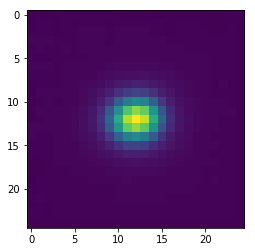

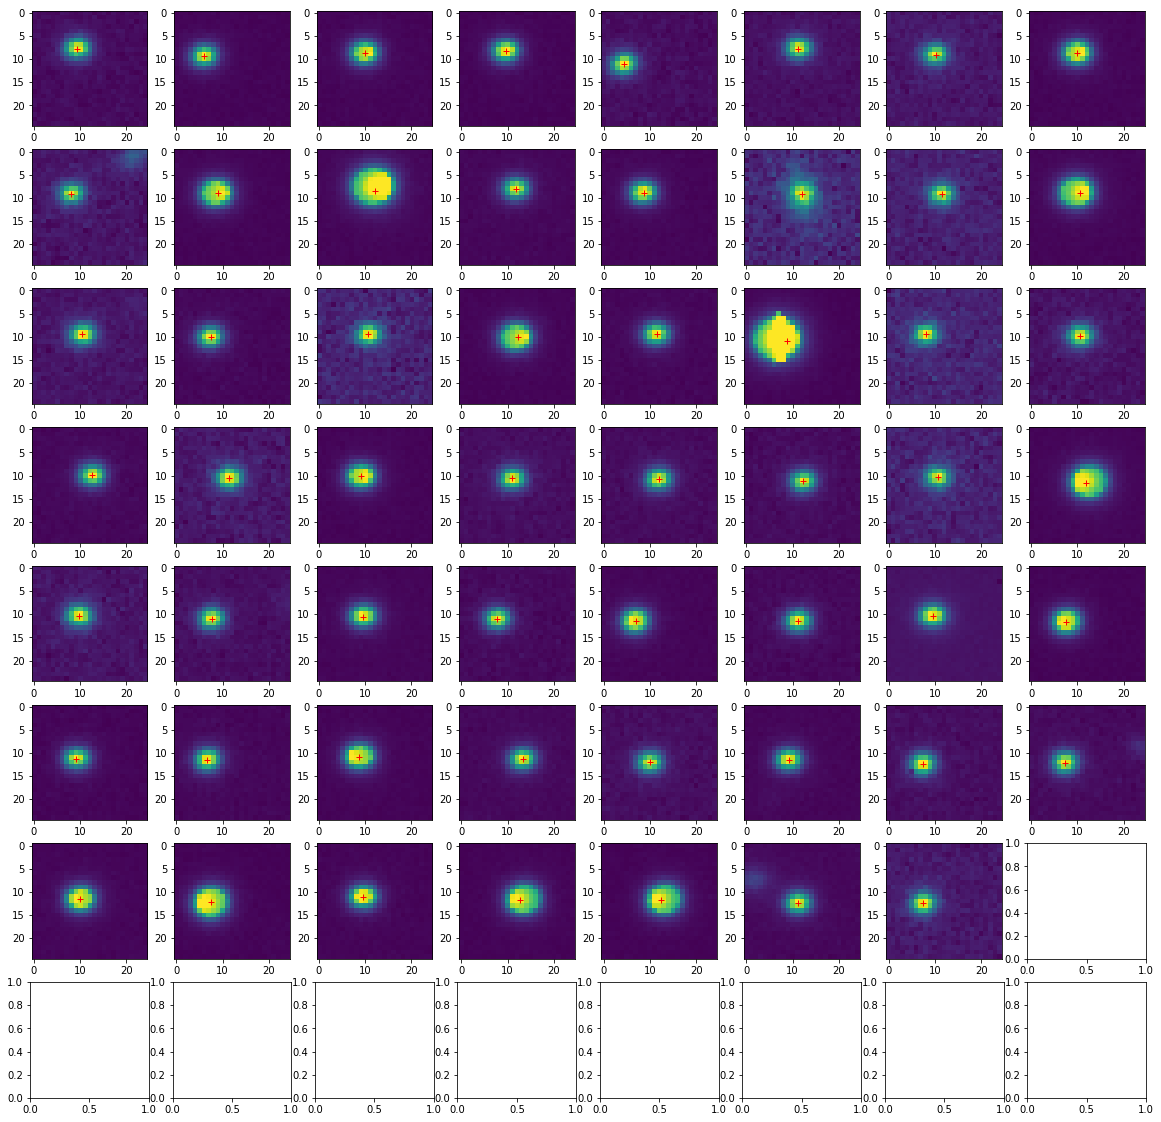

In [5]:
_, sci_stars = make_psf(scidata0, catalog, show=True)

# Update the WCS for the science image

In [6]:
scidata = scidata0.copy()
refine_wcs(scidata.wcs, sci_stars, catalog)

science_filename = os.path.join(workdir, 'science.fits')
scidata.write(science_filename, overwrite=True)

 orig_fun: 3.618614803007723
      fun: 0.877793958995504
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.05084966, 0.25906537, 0.11764918])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 80
      nit: 15
   status: 0
  success: True
        x: array([ 1.57787531e-04, -8.97406941e-05, -2.08974436e-03])


# Actually make the PSF for the science image

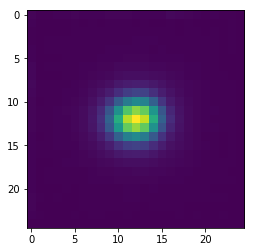

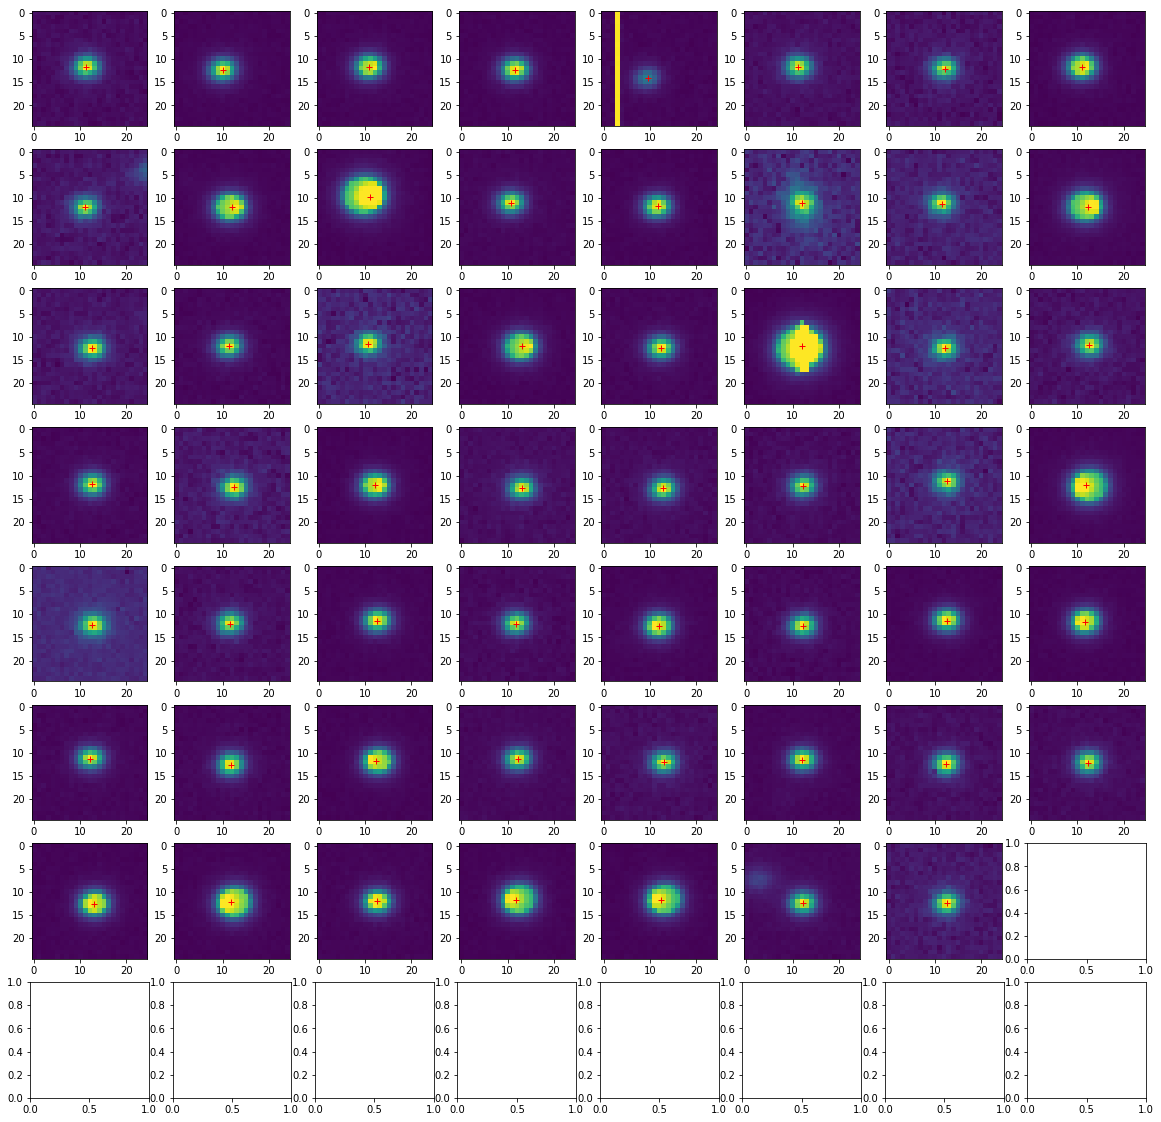

In [7]:
sci_psf, _ = make_psf(scidata, catalog, show=True)

# Download the reference image

In [8]:
refdata0 = download_ps1_image(ra, dec, scidata.meta['filter'])

this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


# Update the WCS for the reference image

PROGRESS: iteration 10 (of max 10) [0.1 s/iter]
 orig_fun: 1.2497655972408732
      fun: 0.14662628776120037
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.020064  ,  0.0438987 , -0.03004858])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 100
      nit: 16
   status: 0
  success: True
        x: array([-1.29470201e-04, -8.98088278e-05,  7.46599677e-05])


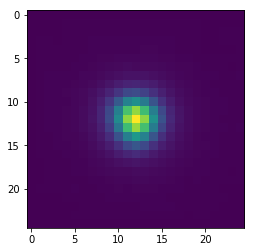

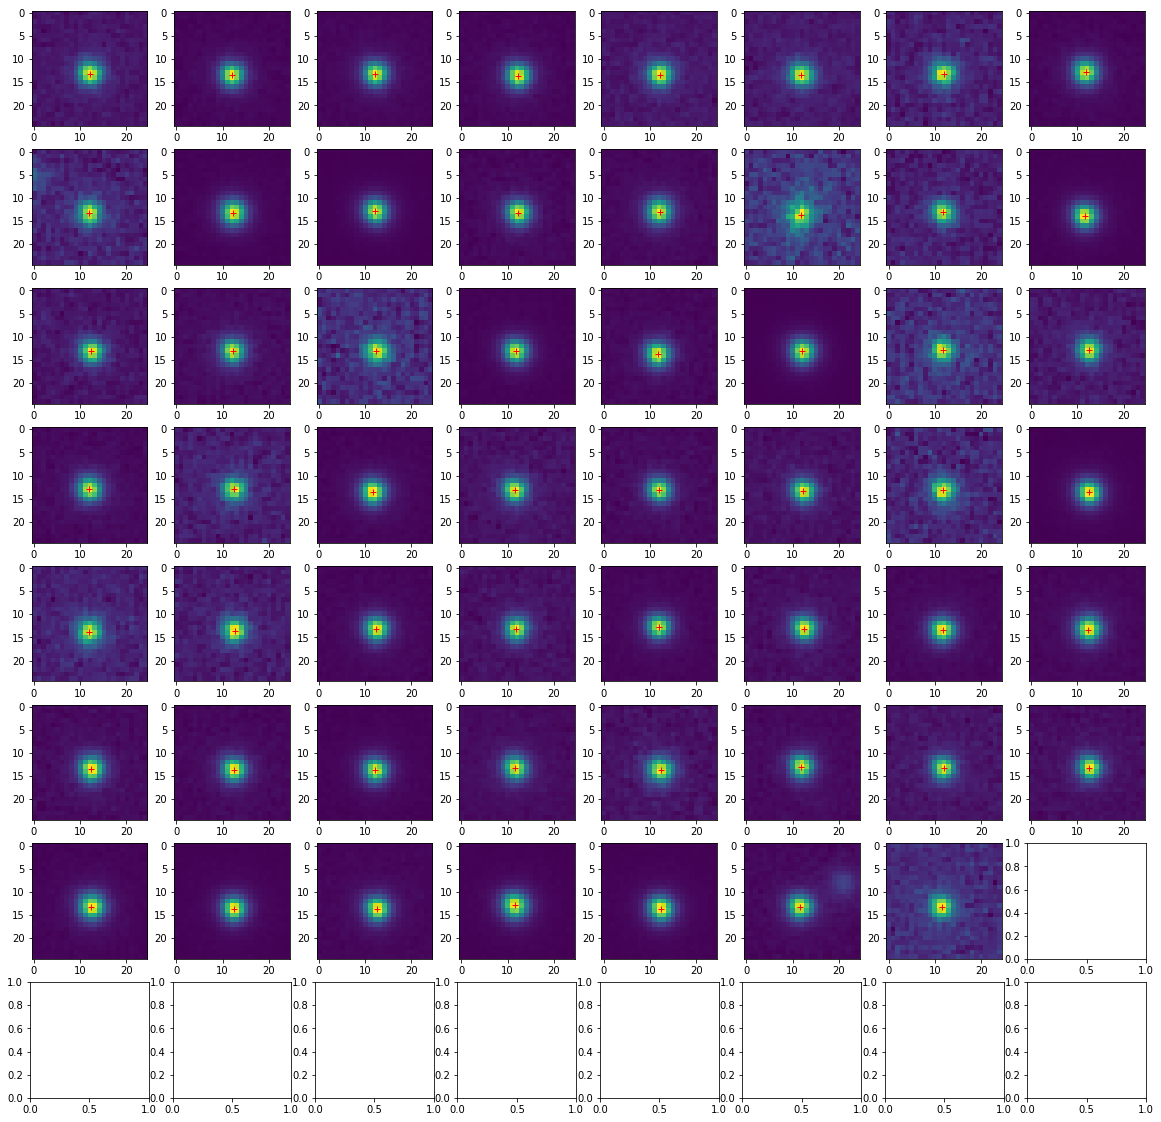

In [9]:
_, ref_stars = make_psf(refdata0, catalog, show=True)
print()
refine_wcs(refdata0.wcs, ref_stars, catalog)

# Reproject the reference image to match the science image

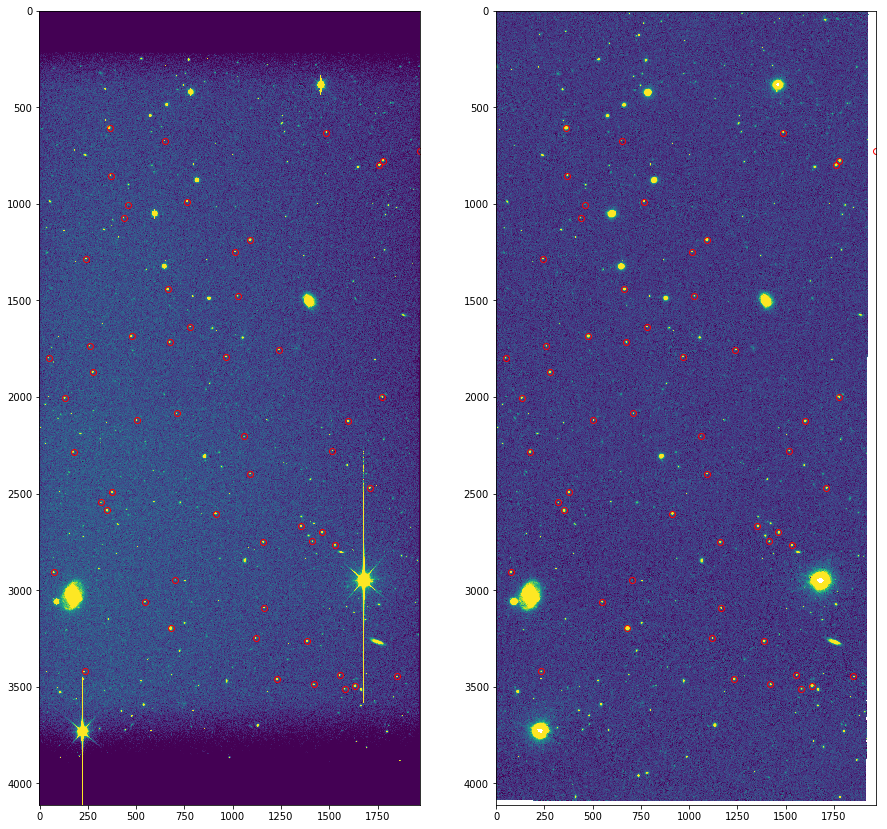

In [10]:
refdata_reproj, refdata_foot = reproject_interp((refdata0.data, refdata0.wcs), scidata.wcs, scidata.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
x, y = scidata.wcs.all_world2pix(catalog['raMean'], catalog['decMean'], 0.)

vmin, vmax = np.percentile(scidata.data, (15., 99.5))
ax1.imshow(scidata.data, vmin=vmin, vmax=vmax)
ax1.plot(x, y, marker='o', mec='r', mfc='none', ls='none')

norm = ImageNormalize(refdata_reproj, PercentileInterval(99.))
ax2.imshow(refdata_reproj, norm=norm)
ax2.plot(x, y, marker='o', mec='r', mfc='none', ls='none')

template_filename = os.path.join(workdir, 'template.fits')
refdata_reproj[np.isnan(refdata_reproj)] = 0.
refdata = CCDData(refdata_reproj, wcs=scidata.wcs, mask=1-refdata_foot, unit='adu')
refdata.write(template_filename, overwrite=True)

# Make the PSF for the reference image

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:664: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


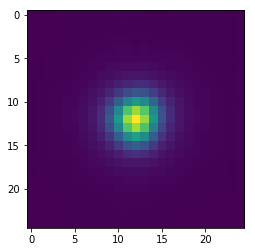

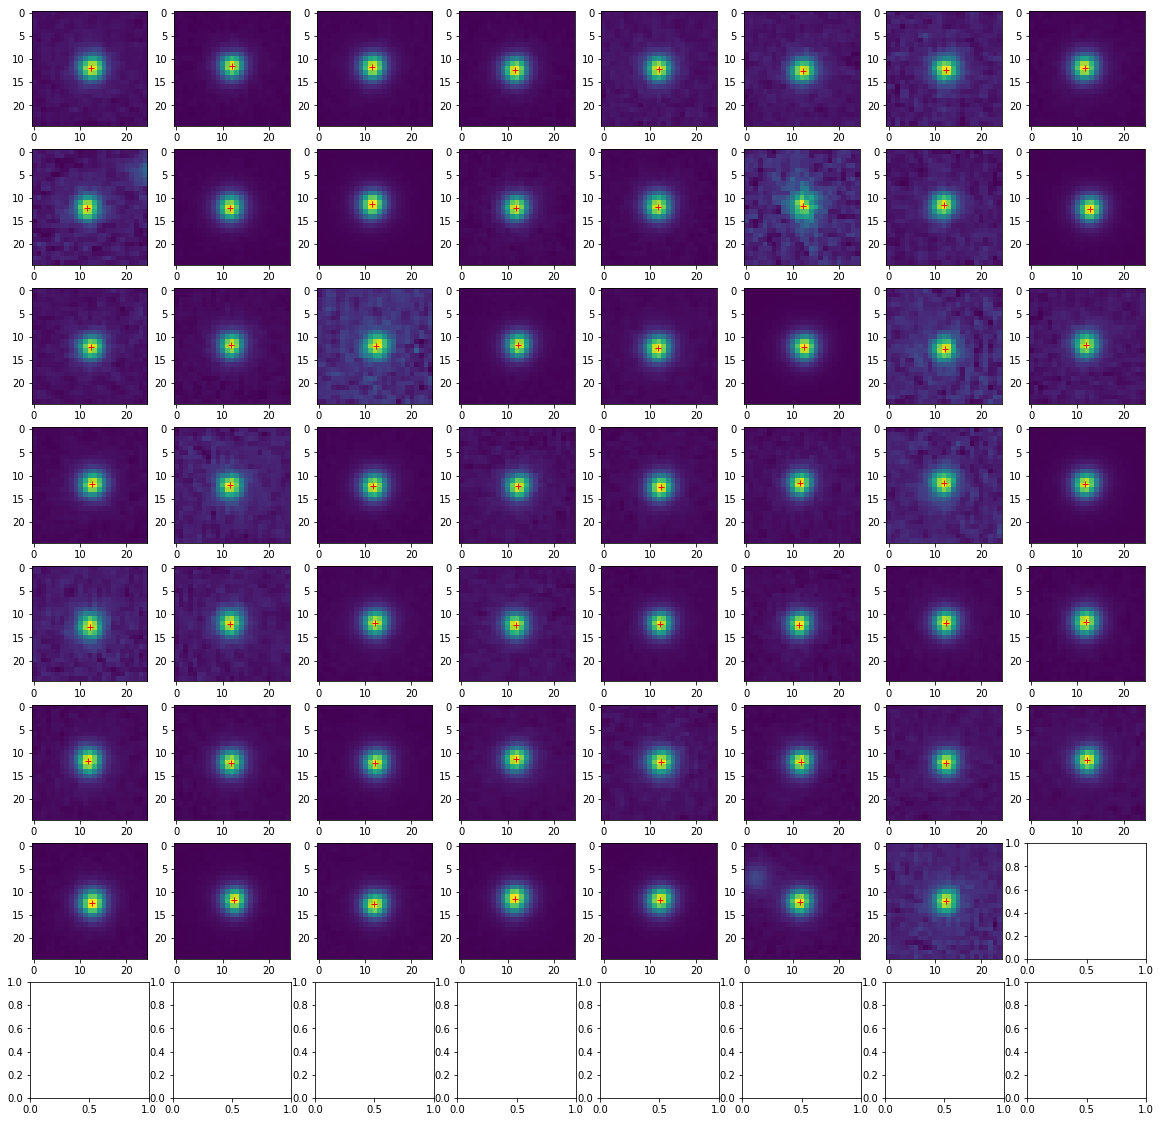

In [11]:
ref_psf, _ = make_psf(refdata, catalog, show=True)

# Subtract the images and view the result

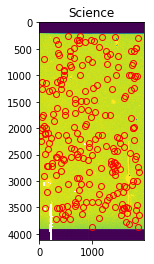

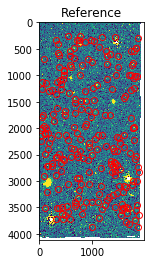

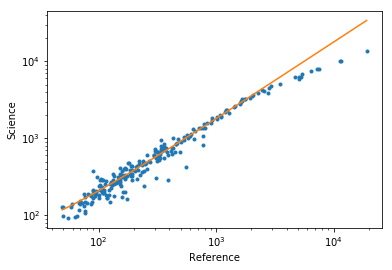

In [12]:
output_filename = os.path.join(workdir, 'diff.fits')
science = ImageClass(scidata.data, sci_psf.data, saturation=65565)
reference = ImageClass(refdata.data, ref_psf.data, refdata.mask)
difference = calculate_difference_image(science, reference, show=True, max_iterations=1)
fits.writeto(output_filename, difference, overwrite=True)

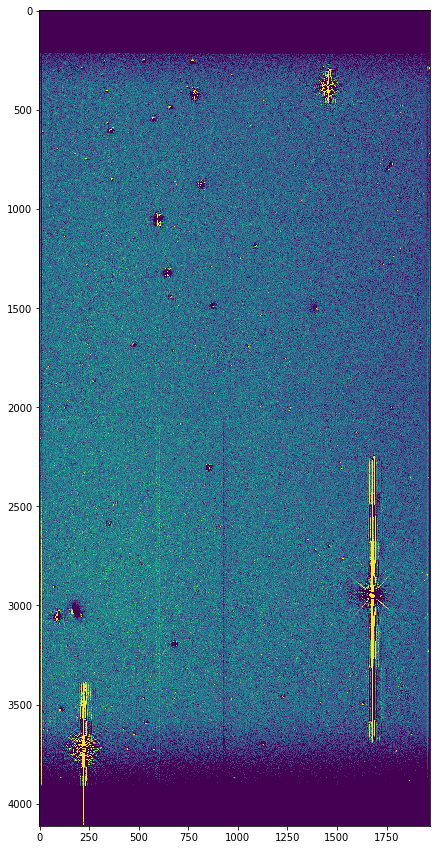

In [13]:
vmin, vmax = np.percentile(difference, (15., 99.5))
plt.figure(figsize=(7., 15.))
plt.imshow(difference, vmin=vmin, vmax=vmax)